# HIGH VALUE CUSTOMER IDENTIFICATION

## SOLUTION PLANNING (IOT)

##### INPUT

Business Problems:
- Selecionar os clientes mais valiosos para integrar um programa de fidelização <b>"Diamond"</b>
- Vendas de um e-commerce online, durante o periodo de 1 ano (November 2015 to December 2017).

##### OUTPUT

1. Relatório com as respostas para as perguntas de negocio:


- Quem são as pessoas elegíveis para participar do programa <b>Diamond</b>?
- Quantos customers farão parte do programa?
- Quais as principais caracteristicas desses clientes?
- Qual o percentual de contribuição  do faturamento, vinda dos customers participantes?
- Qual a expectativa de faturamento desse grupo para os proximos meses?
- Quais as condições para um cliente participar do programa?
- Quais as condições para um cliente ser removido do programa?
- Qual a garantia da eficacia do programa para o restante da base?
- Quais ações o squad de marketing pode realizar para aumentar o faturamento?

##### TASKS

1 - Quem são as pessoas elegíveis para participar do programa?
- O que é ser elegivel? O que são clientes de alto valor?
    - Faturamento:
        - Alto Ticket medio;
        - Alto LTV;
        - Baixa recencia;
        - Alto Basket size;
        - Baixa Probabilidade de Churn;
        - Alta previão LTV;
        - Alta propensão de compra.

- Custo:
    - Baixa taxa de devolução.

- Experiência de compra:
    - Média alta das avaliações

        

2 - Quantos customers farão parte do programa?

- Numero Total de clientes;
- (%) Percentual do grupo


3 - Quais as principais caracteristicas desses clientes?

- Caracteristicas unicas do cliente (Idade, Pais, Salário);
- Atributos da Clusterização.


4 - Qual o percentual de contribuição  do faturamento, vinda dos customers participantes?

- Faturamento total da empresa durante o ano;
- Faturamento (%) apenas do cluster <b>Diamond</b>.



5 - Qual a expectativa de faturamento desse grupo para os proximos meses?

- LTV do grupo;
- Séries Temporais (ARMA, ARIMA, HoltWinter).

6 - Quais as condições para um cliente participar do programa?

- Definir prioridade (Sasonalidade - 1 mes, 3 meses);
- O desempenho do customer estar proximo da média do cluster <b>Diamond</b>.

7 - Quais as condições para um cliente ser removido do programa?

- Definir prioridade (Sasonalidade - 1 mes, 3 meses);
- O desempenho do customer não estar proximo da média do cluster <b>Diamond</b>.

8 - Qual a garantia da eficacia do programa para o restante da base?

- Teste A/B;
- Teste de hipóteses.

9 - Quais ações o squad de marketing pode realizar para aumentar o faturamento?

- Desconto;
- Preferencia de compra;
- Produtos exclusivos;
- Visita a empresa.


# 1.0 - IMPORTS

## 1.1 - LIBRARIES

In [388]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import plotly.express           as px
import seaborn                  as sns
import re
import inflection
import umap.umap_               as umap
from sklearn.cluster            import KMeans, DBSCAN
from sklearn.metrics            import silhouette_score, silhouette_samples
from sklearn.preprocessing      import MinMaxScaler, StandardScaler
from sklearn.decomposition      import PCA
from sklearn.manifold           import TSNE
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from sklearn.ensemble           import RandomForestRegressor
from sklearn.mixture            import GaussianMixture
from scipy.cluster.hierarchy    import linkage, dendrogram, fcluster
from IPython.display            import Image, display



## 1.2 - LOAD DATA

In [389]:
df_raw = pd.read_csv('../dataset/data.csv', encoding='latin-1')

## 1.3 - HELPER FUNCTIONS

### 1.3.1 - PLOT DIMENSIONS

In [390]:
sns.set(rc = {'figure.figsize':(13,5)})

### 1.3.2 - NA VOLUMETRY

In [391]:
def nan_volumetry(data):
    df_na = pd.DataFrame()
    df_na['attributes'] = data.columns
    df_na['volumetry'] = ''
    df_na['percentual'] = ''

    for i in df_na.index:
        volumetry = data[df_na.loc[i, 'attributes']].isna().sum()
        percentual = (volumetry / data['customer_id'].count()) * 100
        df_na.loc[i, 'volumetry'] = volumetry
        df_na.loc[i, 'percentual'] = f"{percentual:.2f}%"  

    return df_na

# 2.0 - DATA DESCRIPTION

In [392]:
df2 = df_raw.copy()

## 2.1 - DATA DIMENSION

In [393]:
print('Total of unique features:\n')
print(df2.apply(lambda x: x.nunique()))
print('\nNumber of rows: {}'.format(df2.shape[0]))
print('Number of cols: {}'.format(df2.shape[1]))

Total of unique features:

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Number of rows: 541909
Number of cols: 8


## 2.2 - RENAME COLUMNS

In [394]:
old_columns = df2.columns
snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, old_columns))
df2.columns = new_columns

## 2.3 - DATA TYPES

In [395]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4 - NAN VOLUMETRY

In [396]:
df2.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [397]:
nan_volumetry(df2)

,attributes,volumetry,percentual
0,invoice_no,0,0.00%
1,stock_code,0,0.00%
2,description,1454,0.36%
3,quantity,0,0.00%
4,invoice_date,0,0.00%
5,unit_price,0,0.00%
6,customer_id,135080,33.20%
7,country,0,0.00%


### 2.4.1 - FILL NA

In [398]:
df_missing = df2.loc[df2['customer_id'].isna(),:]
df_full = df2.loc[~df2['customer_id'].isna(),:]

In [399]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df2 = pd.merge( df2, df_backup, on='invoice_no', how='left' )

# coalesce 
df2['customer_id'] = df2['customer_id_x'].combine_first( df2['customer_id_y'] )

# drop extra columns
df2 = df2.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )
df2.head(6)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,United Kingdom,17850.0


In [400]:
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 2.5 - CHANGE DATA TYPES

In [401]:
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])
df2['customer_id'] = df2['customer_id'].astype(int)

In [402]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

# 3.0 - DESCRIPTIVE STATISTICS

In [403]:
df3 = df2.copy()
num_attributes = df3.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df3.select_dtypes(include = 'object')

## 3.1 - NUMERICAL ATTRIBUTES

In [404]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 3.1.1 - NUMERICAL ATTRIBUTES ANALYSIS

- Negative Quantity (Returning products?)
- Unity Price less than zero (Product discount?)

## 3.2 - CATEGORICAL ATTRIBUTES

In [405]:
cat_attributes.columns

Index(['invoice_no', 'stock_code', 'description', 'country'], dtype='object')

### INVOICE NUMBER

We have Invoice Number with letters and numbers, sendo assim iremos padronizar para uma variavel numerica pois se trata de uma ordem de compra.

In [406]:
df_letter_invoices = df3.loc[df3['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


Observando que a coluna Quantity indicam numeros negativos, podemos assumir que são dados relacionados a descontos, devolução ou estorno (cancelamento) de mercadorias pois correspondem a quantidade total de ordens com letras.

STOCK CODE

Analise de stocke code com apenas caracteres

In [407]:
df3.loc[df3['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
291828,562520,POST,POSTAGE,1,2011-08-05 12:38:00,18.00,France,12599
166693,550953,DOT,DOTCOM POSTAGE,1,2011-04-21 16:17:00,283.00,United Kingdom,20388
320704,C565078,D,Discount,-1,2011-08-31 17:45:00,57.60,United Kingdom,16422
517027,580027,M,Manual,1,2011-12-01 12:01:00,10.00,United Kingdom,14178
196831,C553865,S,SAMPLES,-1,2011-05-19 14:10:00,16.50,United Kingdom,20692
157014,550187,POST,POSTAGE,2,2011-04-14 18:40:00,18.00,Germany,13811
242443,C558347,S,SAMPLES,-1,2011-06-28 14:47:00,6.15,United Kingdom,21062
393707,570841,POST,POSTAGE,2,2011-10-12 14:18:00,18.00,France,12553
242195,558319,DOT,DOTCOM POSTAGE,1,2011-06-28 11:53:00,58.33,United Kingdom,21053
226396,C556796,D,Discount,-96,2011-06-14 14:40:00,0.70,United Kingdom,16013


In [408]:
stock_code_letters = df3.loc[df3['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
stock_code_letters

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### DESCRIPTION

We'll drop the Description column, because its not usefull or bring some insight ou metric to our analysis.

In [409]:
df3.sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
71979,542221,22722,SET OF 6 SPICE TINS PANTRY DESIGN,2,2011-01-26 12:40:00,3.95,United Kingdom,14978
371805,569226,21261,GREEN GOOSE FEATHER CHRISTMAS TREE,2,2011-10-02 14:31:00,2.95,United Kingdom,16930
135883,547918,48188,DOORMAT WELCOME PUPPIES,2,2011-03-28 12:49:00,7.95,United Kingdom,15249
23208,538184,22274,FELTCRAFT DOLL EMILY,6,2010-12-10 10:21:00,2.95,United Kingdom,17880
466534,576329,17012F,ORIGAMI SANDLEWOOD INCENSE/CAND SET,1,2011-11-14 15:22:00,2.46,United Kingdom,22381


### COUNTRY

In [410]:
print('Total of unique Countries: {}'.format(df3['country'].unique()))
print('\n Total of number of unique Countries: {}'.format(df3['country'].nunique()))
print('\n Percentual of orders per country:')
(df3['country'].value_counts(normalize = True)*100).apply(lambda x: '{:.2f}%'.format(x))

Total of unique Countries: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']

 Total of number of unique Countries: 38

 Percentual of orders per country:


country
United Kingdom          91.43%
Germany                  1.75%
France                   1.58%
EIRE                     1.51%
Spain                    0.47%
Netherlands              0.44%
Belgium                  0.38%
Switzerland              0.37%
Portugal                 0.28%
Australia                0.23%
Norway                   0.20%
Italy                    0.15%
Channel Islands          0.14%
Finland                  0.13%
Cyprus                   0.11%
Sweden                   0.09%
Unspecified              0.08%
Austria                  0.07%
Denmark                  0.07%
Japan                    0.07%
Poland                   0.06%
Israel                   0.05%
USA                      0.05%
Hong Kong                0.05%
Singapore                0.04%
Iceland                  0.03%
Canada                   0.03%
Greece                   0.03%
Malta                    0.02%
United Arab Emirates     0.01%
European Community       0.01%
RSA                      0.01%


Quantity of Customers by Country

In [411]:
df3[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 4.0 - FEATURE SELECTION

In [412]:
df4 = df3.copy()

In [413]:
# === Numerical attributes ====
df4 = df4.loc[df4['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df4 = df4[~df4['stock_code'].isin( stock_code_letters) ]

# description
df4 = df4.drop( columns='description', axis=1 )

# map -  
df4 = df4[~df4['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df4 = df4[~df4['customer_id'].isin( [16446] )]

# quantity
df_returns = df4.loc[df3['quantity'] < 0, :]
df_purchases = df4.loc[df3['quantity'] >= 0, :]

# 5.0 - FEATURE ENGINEERING

In [414]:
df5 = df4.copy()

In [415]:
df_reference = df5.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index = True)

## 5.1 - GROSS REVENUE

In [416]:
#gross Revenue (quantity * price)
df_purchase = df_purchases.copy()
df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']


#monetary
df_monetary = df_purchase.loc[:,['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_reference = pd.merge(df_reference, df_monetary, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

## 5.2 - RECENCY - DAY FROM LAST PURCHASE

In [417]:
#recency (Last Day Purchase)
df_recency = df_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df5['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_reference = pd.merge( df_reference, df_recency, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

## 5.3 - QUANTITY OF PURCHASED

In [418]:
#frequency (Quantity of Purchase)
df_freq = (df_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_reference = pd.merge( df_reference, df_freq, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

## 5.4 - QUANTITY OF ITEMS PURCHASED

In [419]:
#frequency (Quantity of Purchase)
df_freq = (df_purchase.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_reference = pd.merge( df_reference, df_freq, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

## 5.5 - QUANTITY OF PRODUCTS PURCHASED

In [420]:
df_freq = (df_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_reference = pd.merge( df_reference, df_freq, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

## 5.6 - AVERAGE TICKET VALUE

In [421]:
#average ticket
df_avg_ticket = df_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_reference = pd.merge( df_reference, df_avg_ticket, on='customer_id', how='left')
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

## 5.7 - AVERAGE RECENCY DAYS

In [422]:
df_aux = df4[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=False )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_reference = pd.merge( df_reference, df_avg_recency_days, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2744
dtype: int64

## 5.8 - FREQUENCY PURCHASE

In [423]:
df_aux = ( df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_reference = pd.merge( df_reference, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_reference.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2744
frequency             91
dtype: int64

## 5.9 - NUMBER OF RETURNS

In [424]:
df_returns = df_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_reference = pd.merge( df_reference, df_returns, how='left', on='customer_id' )
df_reference.loc[df_reference['qtde_returns'].isna(), 'qtde_returns'] = 0

df_reference.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2744
frequency             91
qtde_returns           0
dtype: int64

## 5.10 - BASKET SIZE

In [425]:
df_aux = ( df_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_reference = pd.merge( df_reference, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_reference.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2744
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

## 5.11 - UNIQUE ITENS BASKET SIZE

In [426]:
df_aux = ( df_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_reference = pd.merge( df_reference, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_reference.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2744
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

## 5.12 - CLEANING NA

In [427]:
df_reference = df_reference.dropna()
df_reference.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

# 6.0 - EXPLORATORY DATA ANALYSIS (EDA)

In [428]:
df6 = df_reference.copy()

## 6.1 - UNIVARIATE ANALYSIS

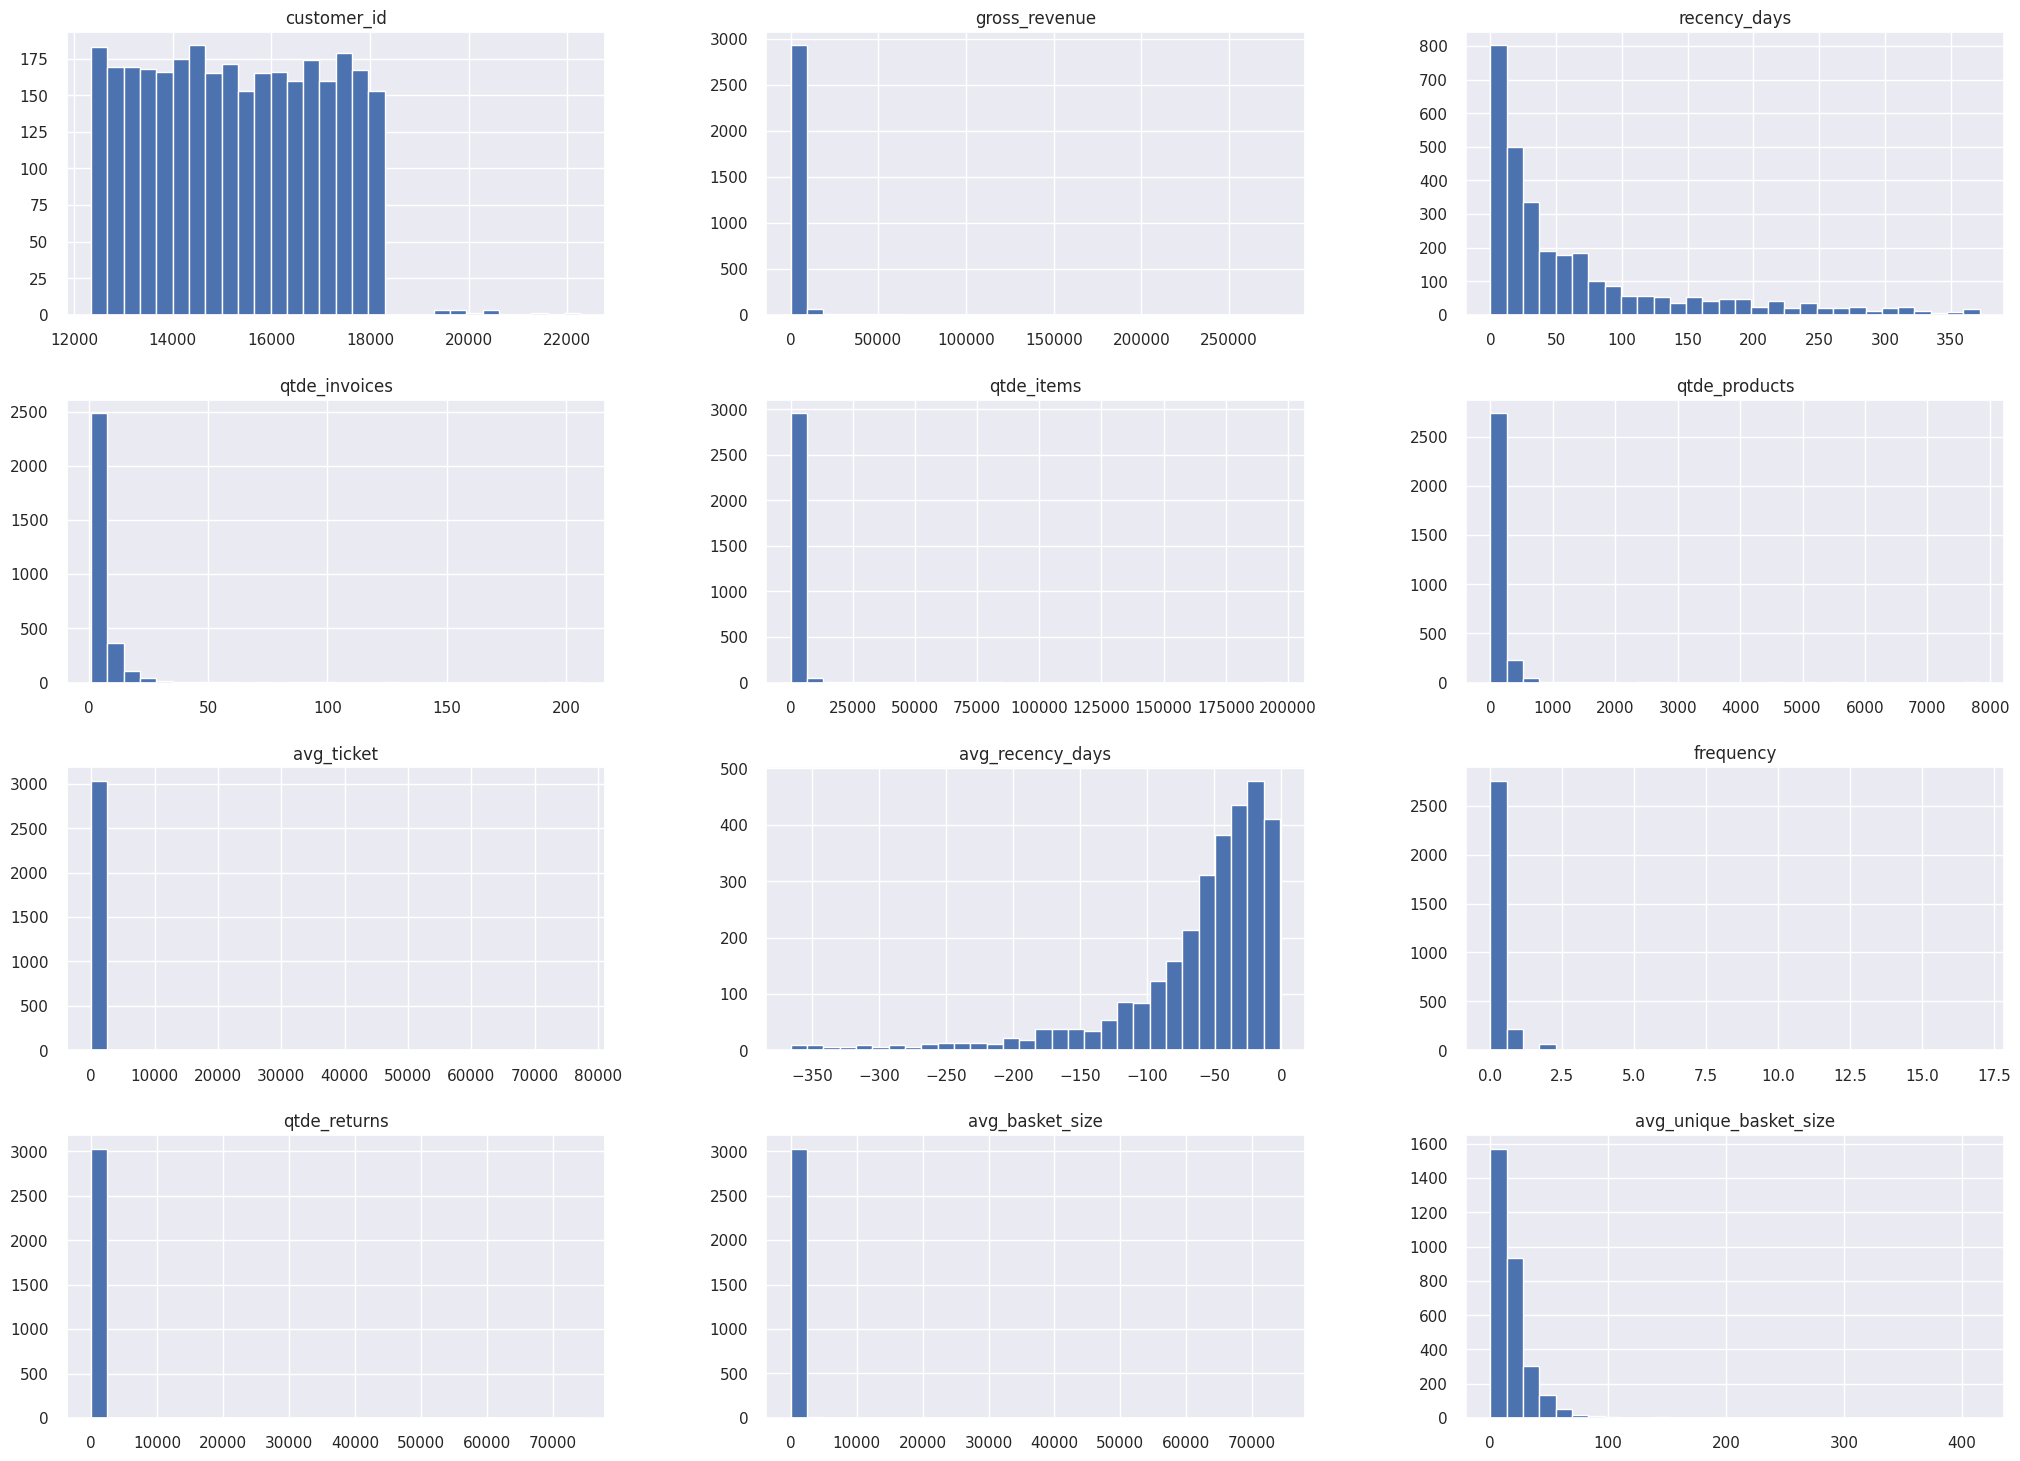

In [429]:
df6.hist(figsize=(25, 18), bins=30)
plt.show()

### GROSS REVENUE

In [430]:
print('Max: {}'.format(df6['gross_revenue'].max()))
print('Min: {}'.format(df6['gross_revenue'].min()))
print('Mean: {}'.format(np.around(df6['gross_revenue'].mean(), 2)))
print('Median: {}'.format(np.around(df6['gross_revenue'].median(), 2)))
print('Standart Deviation: {}'.format(np.around(df6['gross_revenue'].std(), 2)))
print('Coefficient of variation: {}'.format((df6['gross_revenue'].mean() / df6['gross_revenue'].std())*100))

Max: 279138.02
Min: 6.2
Mean: 2694.55
Median: 1066.15
Standart Deviation: 10142.2
Coefficient of variation: 26.567683286420706


In [431]:
df6[['customer_id','gross_revenue']].sort_values('gross_revenue',ascending = False).head(10)

,customer_id,gross_revenue
1017,14646,279138.02
492,18102,259657.30
433,17450,194550.79
66,14911,140450.72
1150,12415,124564.53
190,14156,117379.63
15,17511,91062.38
1381,12346,77183.60
12,16029,72882.09
955,16684,66653.56


In [432]:
df6[df6['customer_id'] == 14646].T

,1017
customer_id,14646.000000
gross_revenue,279138.020000
recency_days,1.000000
qtde_invoices,72.000000
qtde_items,196844.000000
qtde_products,2060.000000
avg_ticket,135.503893
avg_recency_days,-5.555556
frequency,0.203390
qtde_returns,288.000000


### RECENCY DAYS

In [433]:
print('Max: {}'.format(df6['recency_days'].max()))
print('Min: {}'.format(df6['recency_days'].min()))
print('Mean: {}'.format(df6['recency_days'].mean()))
print('Median: {}'.format(df6['recency_days'].median()))
print('Standart Deviation: {}'.format(df6['recency_days'].std()))
print('Coefficient of variation: {}'.format((df6['recency_days'].mean() / df6['recency_days'].std())*100))

Max: 372.0
Min: 0.0
Mean: 65.93978282329714
Median: 32.0
Standart Deviation: 79.96110390068834
Coefficient of variation: 82.46482302844933


In [434]:
df6[['customer_id','recency_days']].sort_values('recency_days',ascending = False).head(10)

,customer_id,recency_days
140,15363,372.0
63,15922,372.0
82,16048,372.0
160,16781,371.0
168,15823,371.0
223,13370,371.0
0,17850,371.0
293,14813,369.0
312,15880,368.0
352,16858,368.0


### CORRELATION OF FEATURES

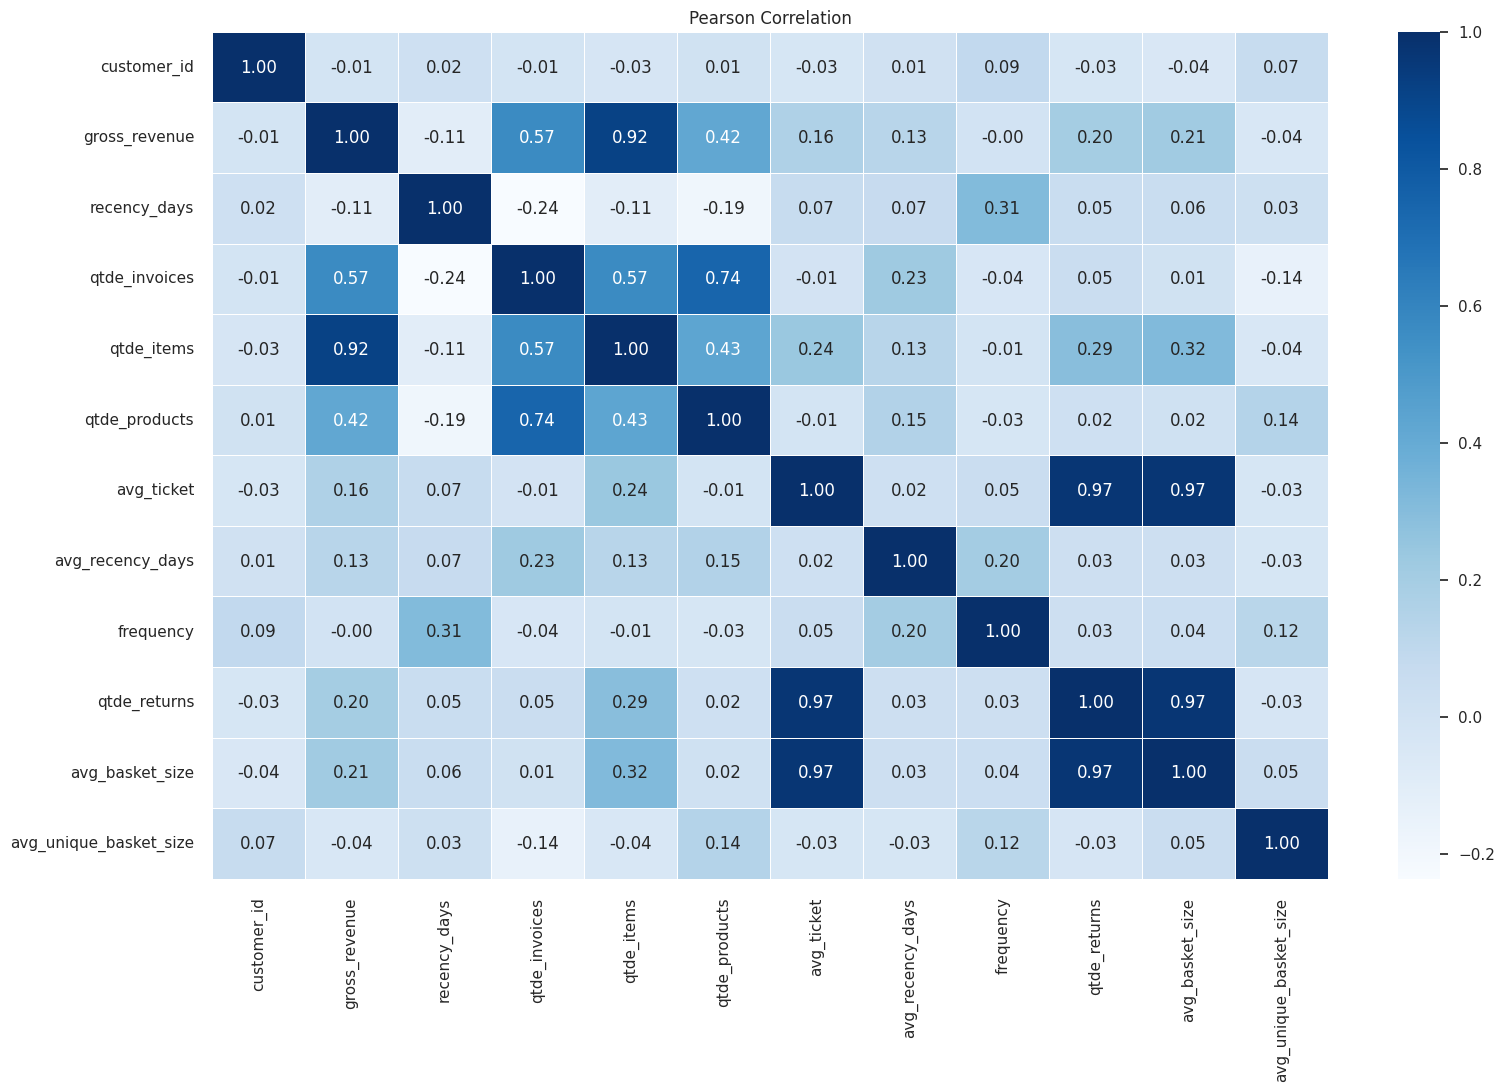

In [435]:
correlation_matrix = df6.corr('pearson')

plt.figure(figsize=(18, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation')
plt.show()


## 6.2 - SPACE STUDY ANALYSIS

In [436]:
df_space = df6.drop(columns = ['customer_id'], axis = 1).copy()
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df_space = df6[cols_selected].copy()
df_space.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtde_products',
       'frequency', 'qtde_returns'],
      dtype='object')

In [437]:
mms = MinMaxScaler()

df_space['gross_revenue']               = mms.fit_transform(df_space[['gross_revenue']])
df_space['recency_days']                = mms.fit_transform(df_space[['recency_days']])
df_space['qtde_products']               = mms.fit_transform(df_space[['qtde_products']])
df_space['frequency']                   = mms.fit_transform(df_space[['frequency']])
df_space['qtde_returns']                = mms.fit_transform(df_space[['qtde_returns']])

### 6.2.1 - PCA ANALYSIS

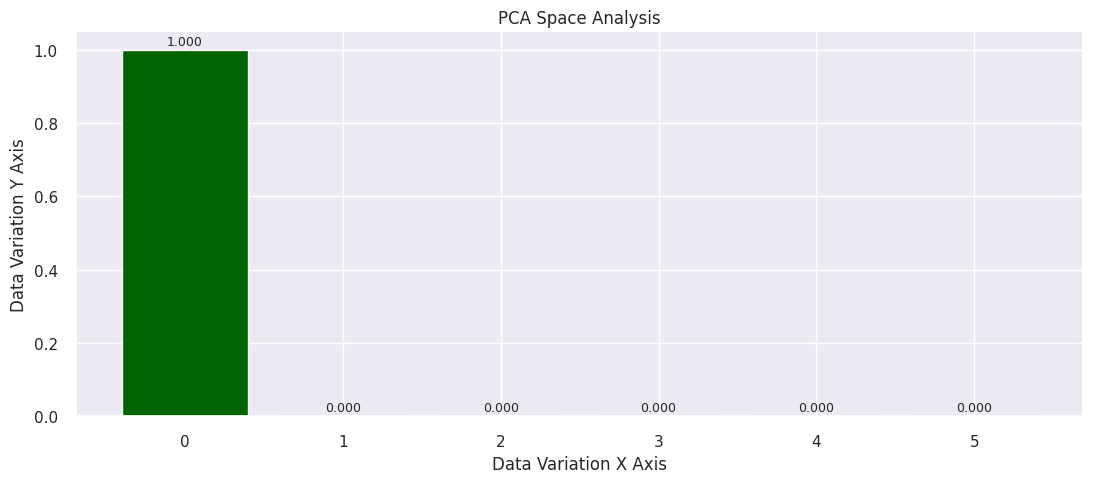

In [438]:
pca = PCA(n_components = df_space.shape[1])

principal_components = pca.fit_transform(df_space)

#plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='darkgreen')
plt.title('PCA Space Analysis')
plt.xlabel('Data Variation X Axis')
plt.ylabel('Data Variation Y Axis')

for i, explained_var in enumerate(pca.explained_variance_ratio_):
    plt.text(i, explained_var + 0.005, f'{explained_var:.3f}', ha='center', va='bottom', fontsize=9)

plt.show()

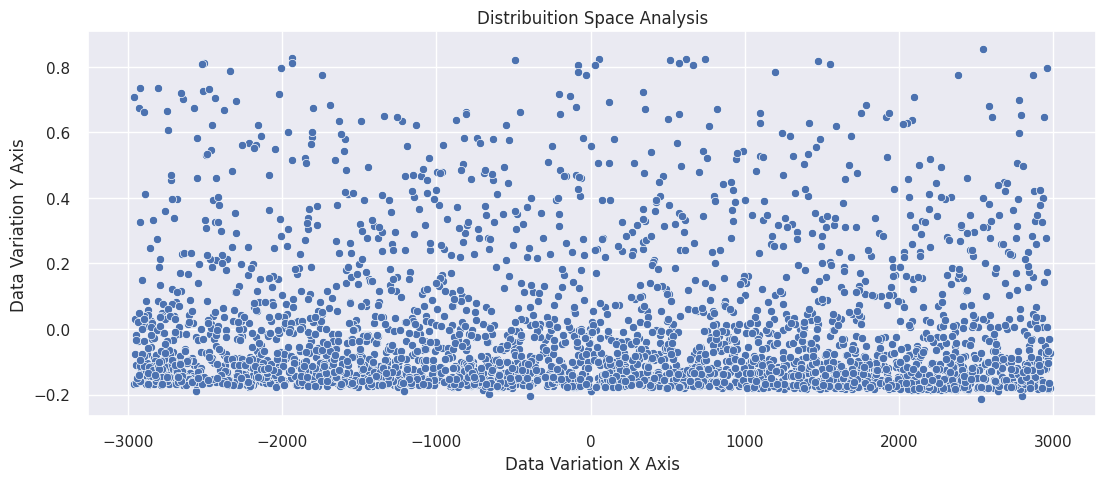

In [439]:
df_pca = pd.DataFrame(principal_components)
df_view = df_pca.loc[df_pca[0] <=3000].copy()
sns.scatterplot(data = df_view, x = 0, y = 1,)
plt.title('Distribuition Space Analysis')
plt.xlabel('Data Variation X Axis')
plt.ylabel('Data Variation Y Axis')
plt.show()

### 6.2.2 - UMAP ANALYSIS

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


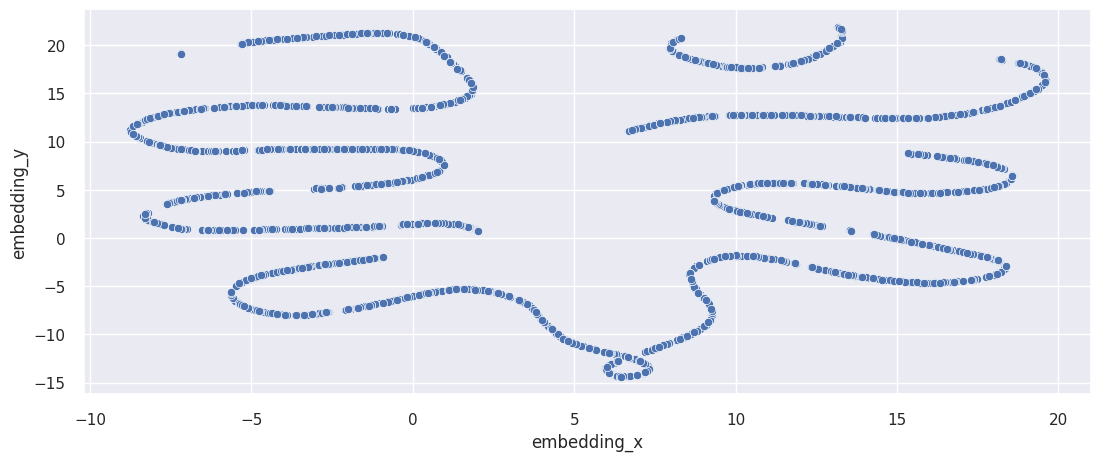

In [440]:
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_space)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_pca, x = 'embedding_x', y = 'embedding_y')

plt.show()

### 6.2.3 - T-SNE ANALYSIS

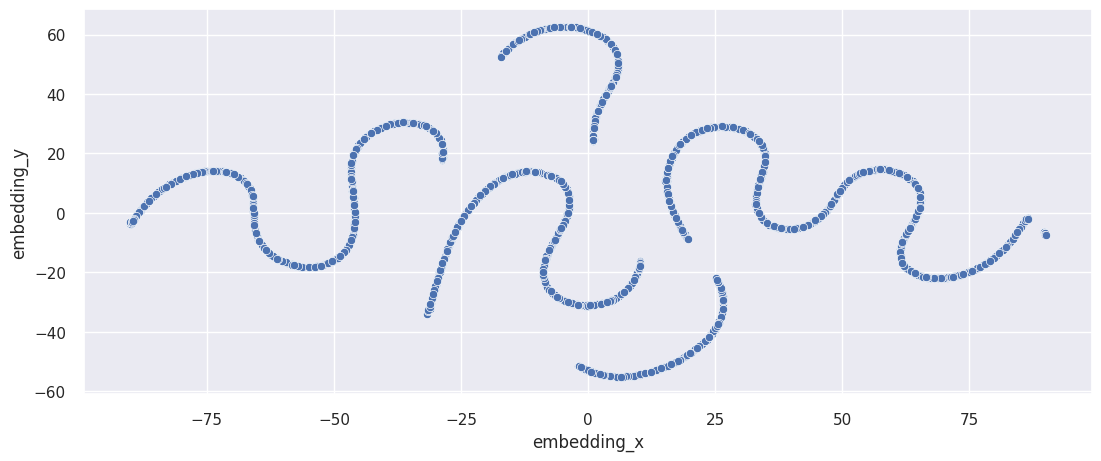

In [441]:
reducer = TSNE(random_state = 42, n_components = 2, n_jobs = -1, )
embedding = reducer.fit_transform(df_space)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_pca, x = 'embedding_x', y = 'embedding_y')

plt.show()

### 6.2.4 - TREE-BASED EMBEDDING ANALYSIS

In [442]:
#dataset split
x_train = df_space.drop(columns = ['customer_id', 'gross_revenue'], axis = 1)
y_train = df_space['gross_revenue']

#model definition
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)

#model training
rf_model.fit(x_train, y_train)

#leaf
leaf = rf_model.apply(x_train)

#dataframe leaf
df_leaf = pd.DataFrame(leaf)
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3746,3656,3622,3746,3397,3739,3559,3486,3677,3724,...,3541,3483,3532,3645,3536,3639,3720,3823,3563,3625
1,3622,3532,3478,3236,3347,3359,2960,3111,3556,3135,...,3424,3081,3446,3401,3439,3479,3117,3145,3410,3228
2,3701,3574,3563,3280,3373,3107,3532,3511,3470,3676,...,3422,3492,3592,3455,3533,3551,3654,3702,3604,3635
3,1210,436,406,425,1332,843,1037,624,429,1044,...,1059,466,1099,895,1230,1248,887,369,820,770
4,495,587,69,658,719,1058,91,477,686,738,...,442,931,465,732,585,498,550,759,123,1062


/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


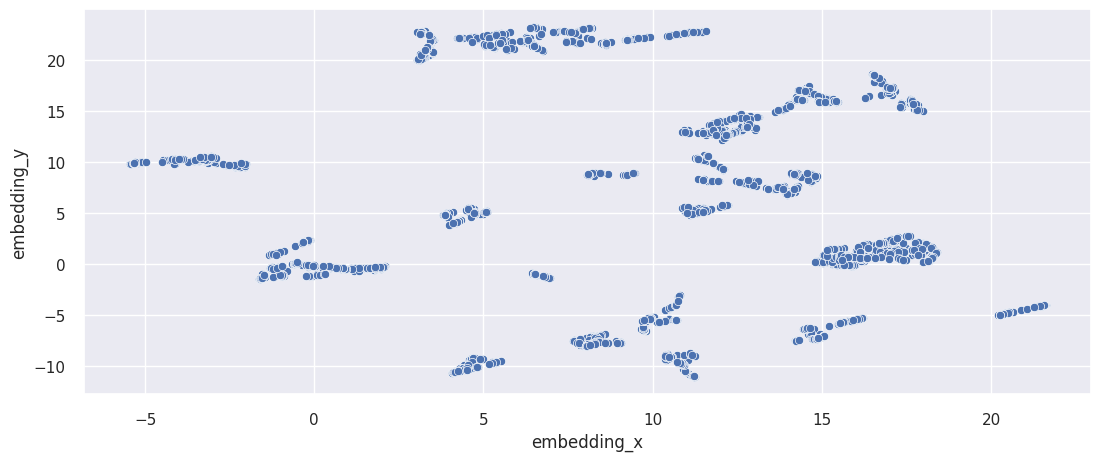

In [443]:
#Reduce of dimensionality
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_tree, x = 'embedding_x', y = 'embedding_y')

plt.show()

# 7.0 - DATA PREPARATION

In [444]:
df7 = df_tree.copy()


## 7.1 - RESCALING

In [445]:
#mms = MinMaxScaler()

#df7['gross_revenue']            = mms.fit_transform(df7[['gross_revenue']])
#df7['recency_days']             = mms.fit_transform(df7[['recency_days']])
#df7['quantity_stock_code']      = mms.fit_transform(df7[['quantity_stock_code']])
#df7['frequency']                = mms.fit_transform(df7[['frequency']])
#df7['returns']                  = mms.fit_transform(df7[['returns']])


# 8.0 - HYPERPARAMETER FINE-TUNNING

In [446]:
df8 = df7.copy()

In [447]:
#cols_selected = df8[['customer_id','gross_revenue', 'recency_days', 'quantity_stock_code', 'frequency', 'returns']]
#parameter_tuning = cols_selected.copy()
#parameter_tuning = parameter_tuning.drop(columns = ['customer_id'], axis = 1)
parameter_tuning = df8.copy()

In [448]:
parameter_tuning

,embedding_x,embedding_y
0,5.543434,22.580914
1,16.679857,18.211548
2,6.618283,23.148361
3,-2.891562,9.862707
4,10.475513,-5.449882
...,...,...
3034,3.280359,20.977346
3035,14.057353,15.516663
3036,10.747486,-3.611966
3037,14.184395,7.354157


In [449]:
cluster = np.arange(2, 26, 1)

## 8.1 - K-MEANS

In [450]:
kmeans_list = []
for k in cluster:
    #model definition
    kmeans = KMeans(n_clusters = k)

    #model traning
    kmeans.fit(parameter_tuning)

    #validation
    labels = kmeans.predict(parameter_tuning)

    #performance
    sil = silhouette_score(parameter_tuning, labels, metric = 'euclidean')
    kmeans_list.append(sil)

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/

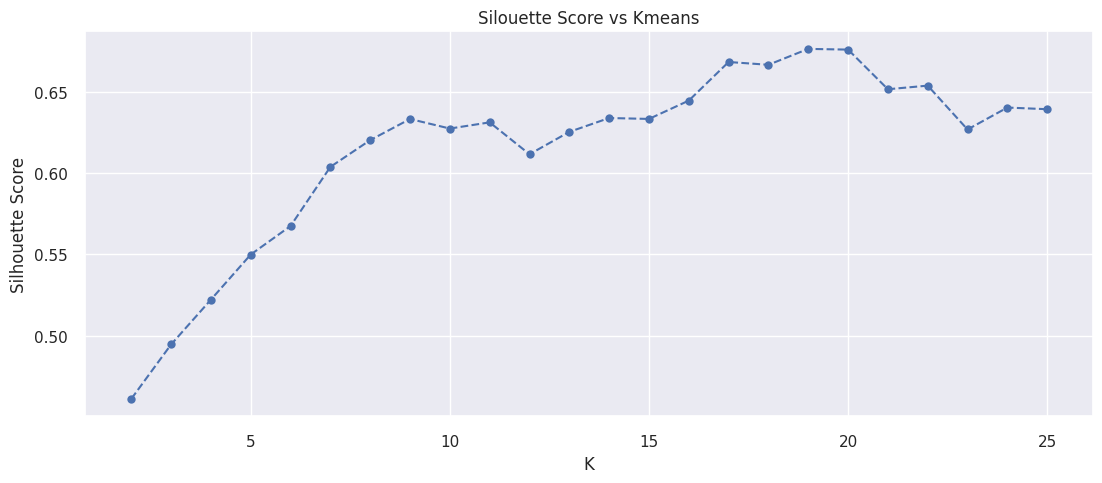

In [451]:
plt.plot(cluster, kmeans_list, linestyle = '--', marker = 'o', color = 'b')
plt.title('Silouette Score vs Kmeans')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show() 


## 8.2 - GAUSSIAN MIXTURE MODEL (GMM)

In [452]:
gmm_list = []
for k in cluster:
    #model definition
    gmm = GaussianMixture(n_components= k)

    #model traning
    gmm.fit(parameter_tuning)

    #validation
    labels = gmm.predict(parameter_tuning)

    #performance
    sil = silhouette_score(parameter_tuning, labels, metric = 'euclidean')
    gmm_list.append(sil)

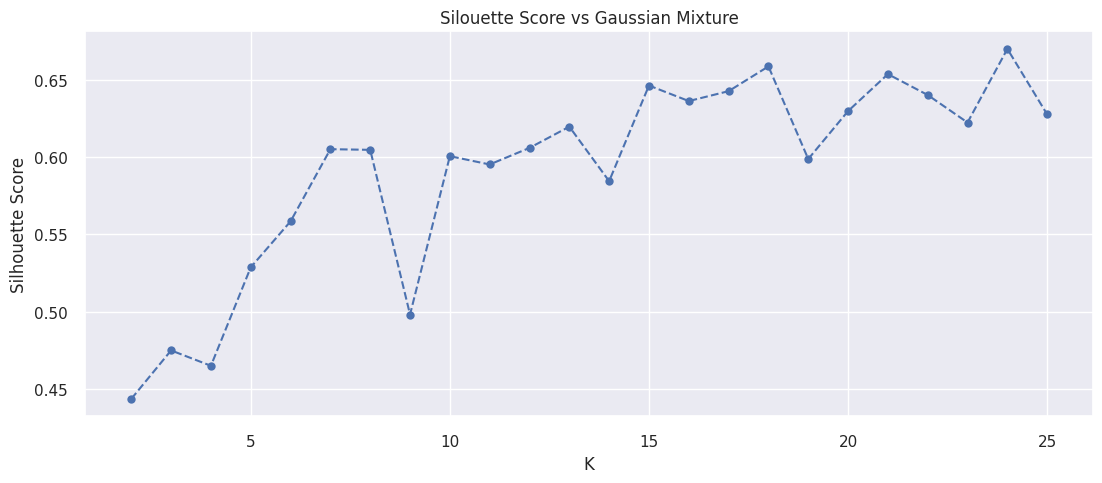

In [453]:
plt.plot(cluster, gmm_list, linestyle = '--', marker = 'o', color = 'b')
plt.title('Silouette Score vs Gaussian Mixture')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show() 

## 8.3 - HIERARCHICAL CLUSTERING

In [454]:
#Definition and training model
hc_model = linkage(parameter_tuning, 'ward')

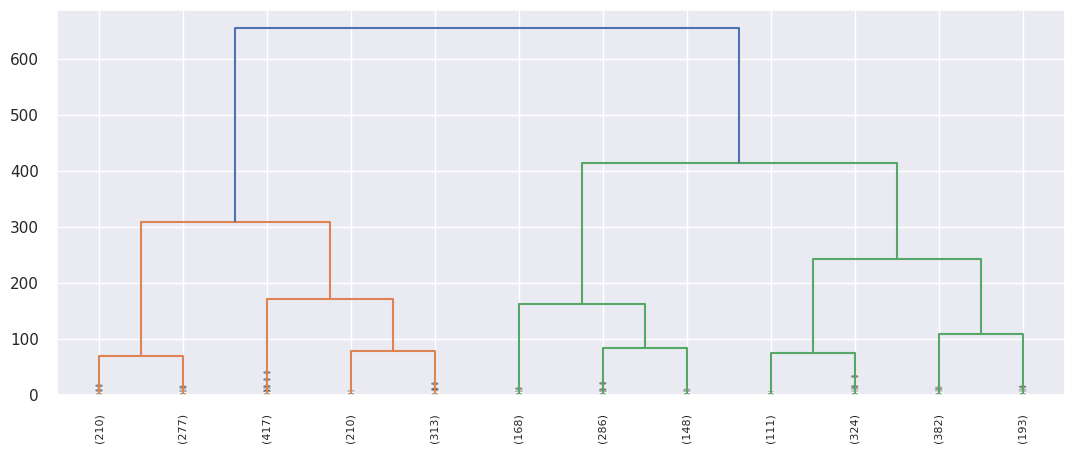

In [455]:
#plot
dendrogram(hc_model, leaf_rotation = 90, leaf_font_size = 8, truncate_mode='lastp', p = 12, show_contracted=True)
plt.show()


### 8.3.1 - HIERARCHICAL CLUSTERING SILHOUETTE SCORE

In [456]:
hc_list = []
for k in cluster:
    #model definition
    hc_model = linkage(parameter_tuning, 'ward')

    #model predict
    labels = fcluster(hc_model, k, criterion = 'maxclust')

    #performance
    sil = silhouette_score(parameter_tuning, labels, metric = 'euclidean')

    hc_list.append(sil)

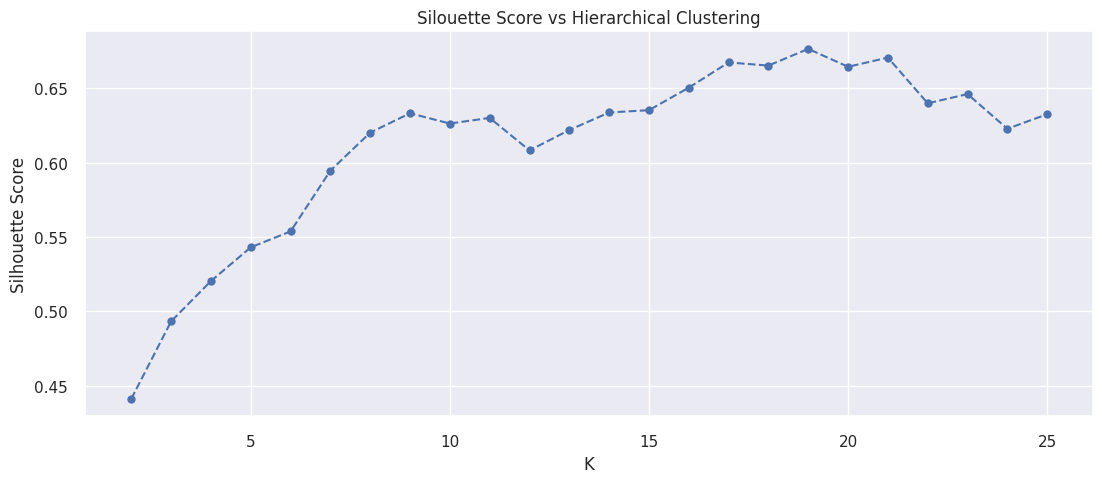

In [457]:
plt.plot(cluster, hc_list, linestyle = '--', marker = 'o', color = 'b')
plt.title('Silouette Score vs Hierarchical Clustering')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show() 

## 8.4 - DBSCAN

In [458]:
#Model definition
dbscan = DBSCAN(eps = 2.00, min_samples = 20)

#model training
labels = dbscan.fit_predict(parameter_tuning)

#performance

sil = silhouette_score(parameter_tuning, labels, metric = 'euclidean')
print('Silhouette Score: {}'.format(sil))
print(' Number of Clusters: {}'.format(len(np.unique(labels))))
print(np.unique(labels))



Silhouette Score: 0.6021504402160645
 Number of Clusters: 11
[ 0  1  2  3  4  5  6  7  8  9 10]


In [459]:
#dbscan_list = [0.6288413264190846, 0.7036052273263511, 0.7318813491682605, 0.7546427923574051, 0.7882920458663134, 0.7882920458663139]

## 8.5 - RESULTS OF PERFORMANCE

In [460]:
df_results = pd.DataFrame({'Kmeans': kmeans_list, 'Gaussian Mixture Model': gmm_list, 'Hierarchical Clustering': hc_list}).T
df_results.columns = cluster
df_results.style.highlight_max(color='darkgreen', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Kmeans,0.461320,0.494748,0.522265,0.549972,0.567498,0.603803,0.620234,0.633213,0.627346,0.631143,0.611561,0.625308,0.633810,0.633252,0.644501,0.668215,0.666501,0.676266,0.675825,0.651487,0.653701,0.626766,0.640237,0.639221
Gaussian Mixture Model,0.443512,0.474872,0.464928,0.528634,0.558378,0.605081,0.604654,0.498081,0.600565,0.595191,0.605907,0.619650,0.584382,0.646267,0.636219,0.642621,0.658632,0.598713,0.629730,0.653648,0.640143,0.622326,0.669973,0.627553
Hierarchical Clustering,0.441029,0.493170,0.520318,0.543032,0.553729,0.594614,0.620234,0.633213,0.626326,0.630123,0.608224,0.621967,0.633752,0.635318,0.650451,0.667427,0.665326,0.676553,0.664500,0.670712,0.639937,0.646159,0.622799,0.632595


# 9.0 - MACHINE LEARNING MODEL

## 9.1 - K-MEANS

In [462]:
#model definition
k = 8
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

#model training
kmeans.fit(parameter_tuning)

#clustering
labels = kmeans.labels_

### 9.1.1 - CLUSTER PERFOMANCE

In [463]:
print('WSS Value: {}'.format(kmeans.inertia_))
print('Silhouette Score Value: {}'.format(silhouette_score(parameter_tuning, labels, metric = 'euclidean')))

WSS Value: 23167.66015625
Silhouette Score Value: 0.6202337145805359


### 9.1.2 - CLUSTER ANALYSIS

In [464]:
df10 = parameter_tuning.copy()
df10['cluster'] = labels
df10.head(10)

,embedding_x,embedding_y,cluster
0,5.543434,22.580914,4
1,16.679857,18.211548,2
2,6.618283,23.148361,4
3,-2.891562,9.862707,0
4,10.475513,-5.449882,5
5,11.311625,10.355288,1
6,5.332528,22.505344,4
7,15.407749,0.856821,7
8,3.241874,22.754866,4
9,4.330956,4.272226,3


### 9.1.3 - VISUALIZATION INSPECTION

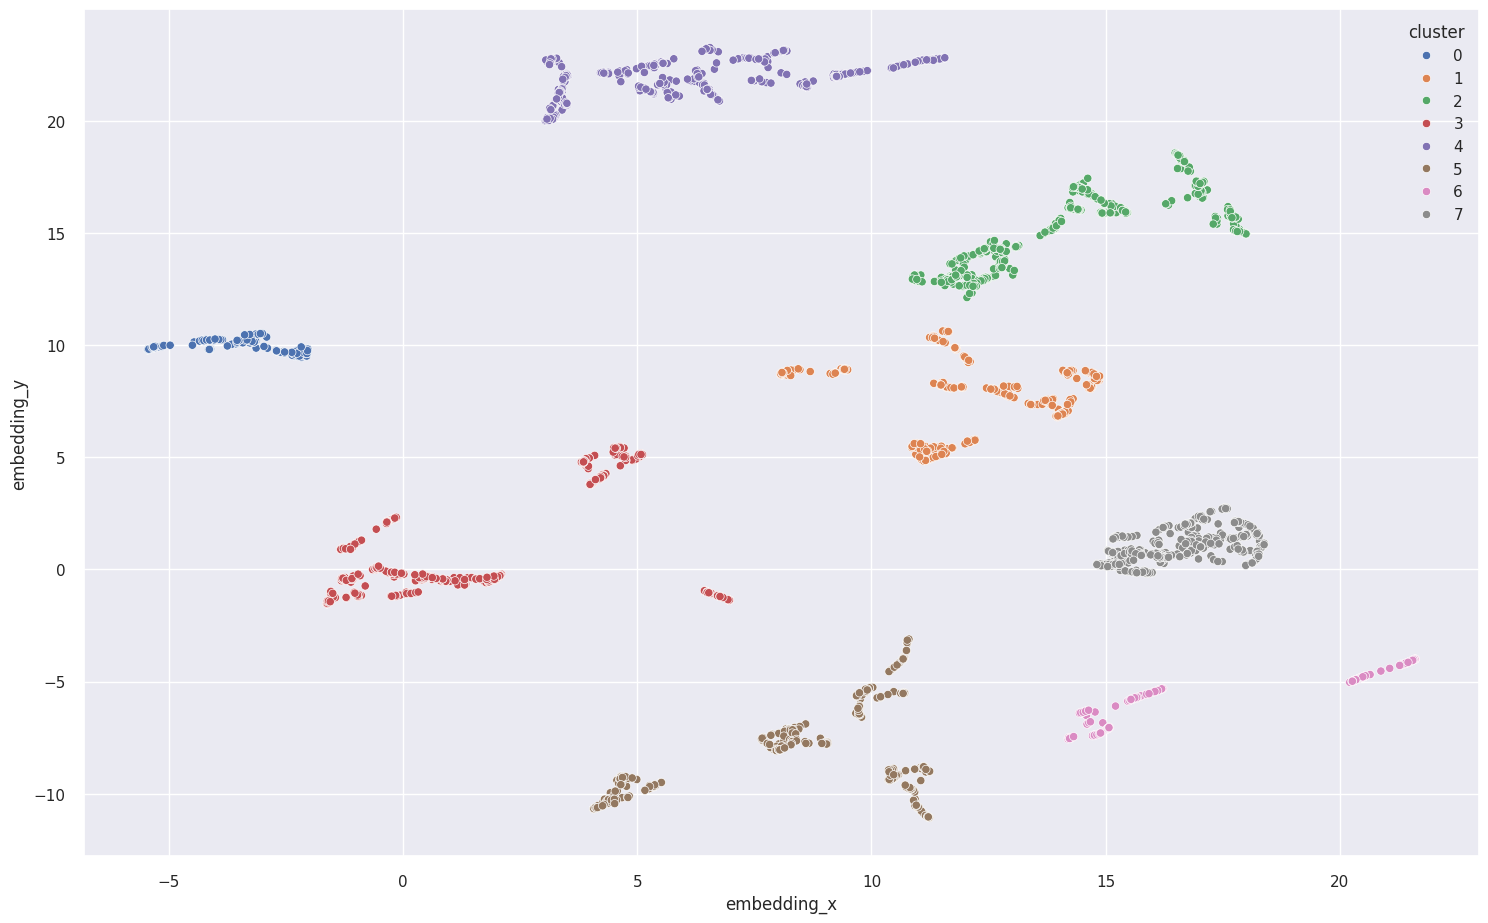

In [465]:
plt.figure(figsize=(18, 11))
sns.scatterplot(data = df10, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette='deep')
plt.show()

## 9.2 - GAUSSIAN MIXTURE MODEL

In [466]:
k = 8
#model definition
gmm = GaussianMixture(n_components= k, random_state=42)

#model traning
gmm.fit(parameter_tuning)

#validation
labels = gmm.predict(parameter_tuning)

#performance
sil = silhouette_score(parameter_tuning, labels, metric = 'euclidean')
gmm_list.append(sil)

### 9.2.1 - CLUSTER PERFOMANCE

In [467]:
print('Silhouette Score Value: {}'.format(silhouette_score(parameter_tuning, labels, metric = 'euclidean')))

Silhouette Score Value: 0.5960385799407959


### 9.2.2 - CLUSTER ANALYSIS

In [468]:
df10 = parameter_tuning.copy()
df10['cluster'] = labels
df10.head(10)

,embedding_x,embedding_y,cluster
0,5.543434,22.580914,1
1,16.679857,18.211548,5
2,6.618283,23.148361,1
3,-2.891562,9.862707,6
4,10.475513,-5.449882,4
5,11.311625,10.355288,3
6,5.332528,22.505344,1
7,15.407749,0.856821,0
8,3.241874,22.754866,1
9,4.330956,4.272226,2


### 9.2.3 - VISUALIZATION INSPECTION

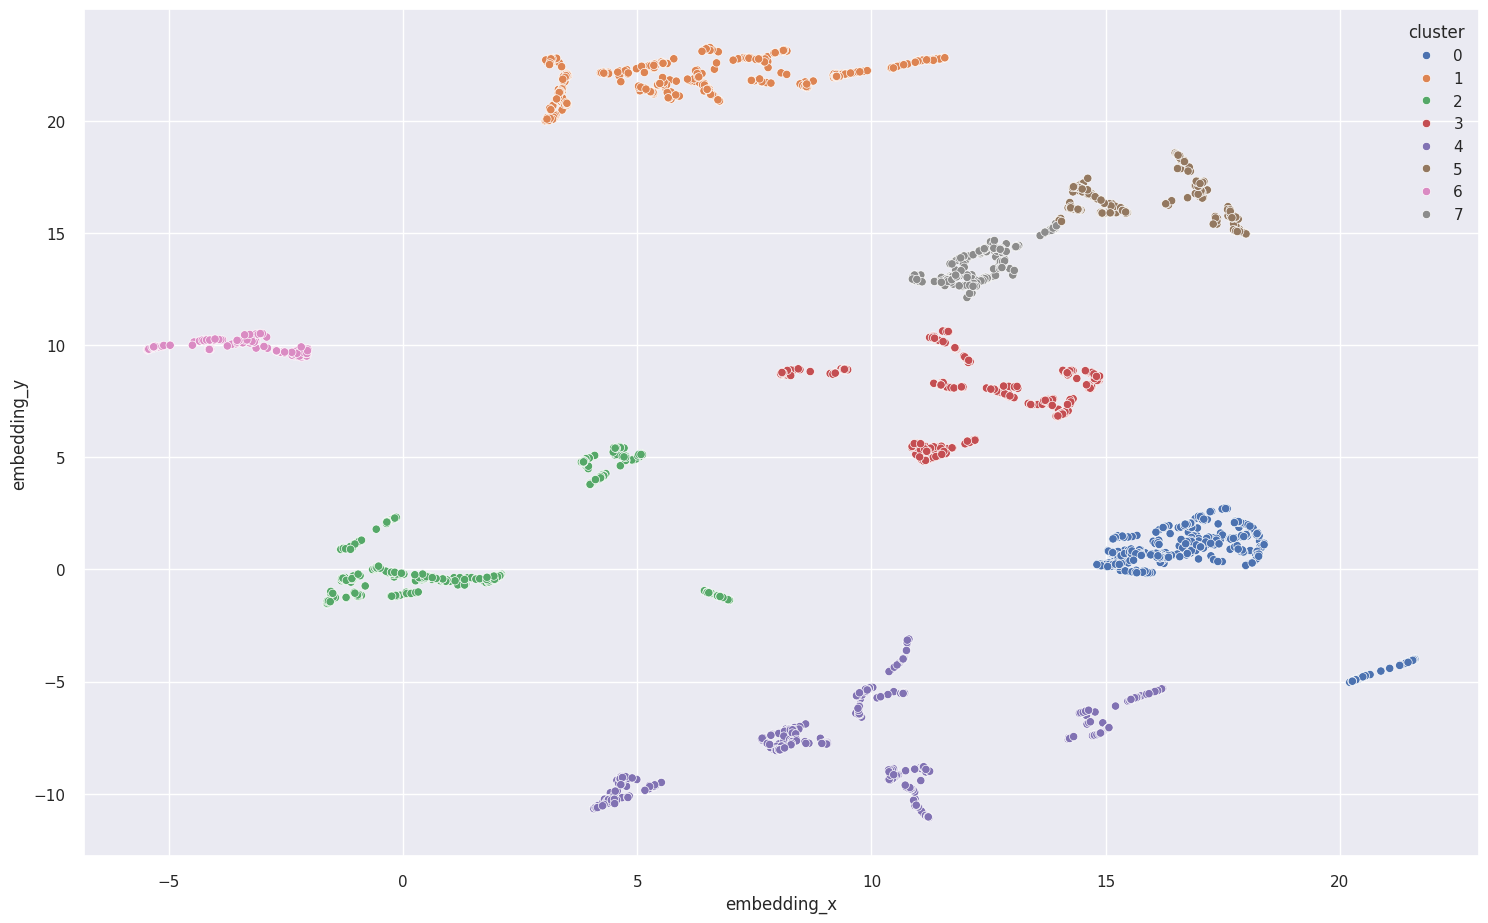

In [469]:
plt.figure(figsize=(18, 11))
sns.scatterplot(data = df10, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette='deep')
plt.show()

# 10.0 - VISUALIZATION INSPECTION

## 10.1 - 10.1 - 2D PLOT

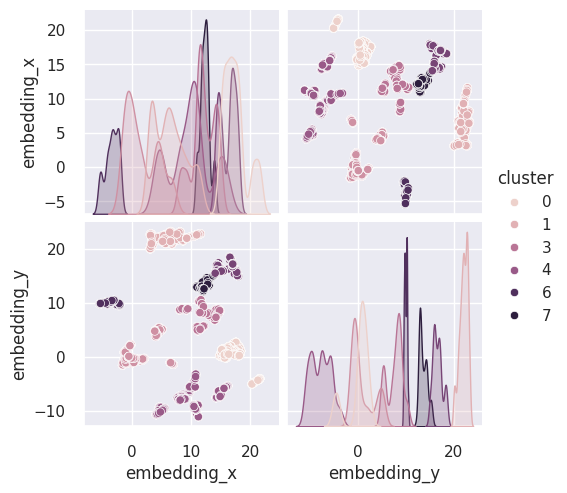

In [470]:
df_viz = df10.copy()
sns.pairplot(df_viz, hue = 'cluster')
plt.show()

## 10.2 - UMAP - HIGH DIMENSIONALITY

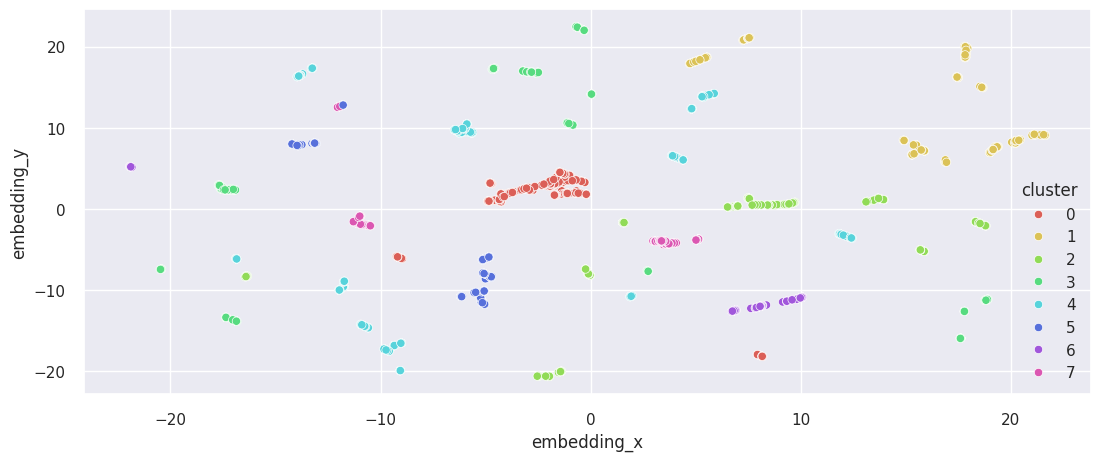

In [471]:
reducer = umap.UMAP(random_state = 42, n_neighbors = 200, n_jobs = 1)
embedding = reducer.fit_transform(parameter_tuning)

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_viz, x = 'embedding_x', y = 'embedding_y', 
                hue = 'cluster', 
                palette = sns.color_palette( 'hls', n_colors = len(df_viz['cluster'].unique())))

plt.show()

## 10.4 - CLUSTER PROFILE

In [472]:
df_profile = df6[cols_selected].copy()
df_profile['cluster'] = labels

In [473]:
# Number of customer
df_cluster = df_profile[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['percentual_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df_profile[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df_profile[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df_profile[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df_profile[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df_profile[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )
df_cluster = df_cluster.sort_values('gross_revenue', ascending=False)

new_order_comuns = ['customer_id', 'cluster', 'percentual_customer', 'frequency','recency_days', 'qtde_products', 'qtde_returns', 'gross_revenue']
df_cluster = df_cluster[new_order_comuns]
df_cluster

,customer_id,cluster,percentual_customer,frequency,recency_days,qtde_products,qtde_returns,gross_revenue
1,487,1,16.025008,0.099853,20.839836,419.258727,298.689938,9544.570739
5,289,5,9.509707,0.170576,49.083045,154.152249,26.975779,3028.327301
7,234,7,7.699901,0.021513,38.213675,124.525641,20.367521,2164.522222
3,417,3,13.721619,0.108976,56.103118,88.611511,10.906475,1803.204005
2,434,2,14.281013,0.103137,71.760369,45.039171,6.221198,1069.551959
0,461,0,15.169464,0.274366,95.787419,46.939262,6.806941,1039.054881
6,168,6,5.528134,0.179553,88.928571,27.952381,4.148810,798.631429
4,549,4,18.065153,0.244711,97.409836,14.606557,16.331512,600.265027


 DIAMOND - CLUSTER 01 (Candidate High Value Customer):
 - Total of customers: 487 (16.03% of all customers)
 - Average of Gross Revenue: $9,544.57
 - Average of Recency Days: 20
 - Average of invoice number: 419
 - Average of Returns: 298
 - Average Purchase Frequency: 0.09%

 <br>

SILVER PRODUCTS - CLUSTER 05:
 - Total of customers: 523 (17.21% of all customers)
 - Average of Gross Revenue: $2,641.84
 - Average of Recency Days: 44
 - Average of invoice number: 140
 - Average of Returns: 24
 - Average Purchase Frequency: 0.10%

 <br>
 
BRONZE MONEY CLUSTER 07:
 - Total of customers: 417 (13.72% of all customers)
 - Average of Gross Revenue: $1,803.20
 - Average of Recency Days: 56
 - Average of invoice number: 88
 - Average of Returns: 10
 - Average Purchase Frequency: 0.10%

 <br>
 
BRONZE PRODUCTS CLUSTER 03:
 - Total of customers: 382 (12.57% of all customers)
 - Average of Gross Revenue: $1,198.02
 - Average of Recency Days: 61
 - Average of invoice number: 54
 - Average of Returns: 7
 - Average Purchase Frequency: 0.09%

 <br>
 
SILVER LESS DAYS - CLUSTER 02:
 - Total of customers: 343 (14.28% of all customers)
 - Average of Gross Revenue: $1,069.55
 - Average of Recency Days: 71
 - Average of invoice number: 45
 - Average of Returns: 6
 - Average Purchase Frequency: 0.09%

 <br>
 
SILVER LOWER PURCHASE - CLUSTER 0:
 - Total of customers: 168 (5.53% of all customers)
 - Average of Gross Revenue: $798.63
 - Average of Recency Days: 88
 - Average of invoice number: 27
 - Average of Returns: 4
 - Average Purchase Frequency: 0.17%

 <br>
 
SILVER STOP RETURNS - CLUSTER 06:
 - Total of customers: 435 (14.31% of all customers)
 - Average of Gross Revenue: $656.33
 - Average of Recency Days: 94	
 - Average of invoice number: 14
 - Average of Returns: 19
 - Average Purchase Frequency: 0.06%

 <br>
 
BRONZE LOWER PURCHASE - CLUSTER 04:
 - Total of customers: 193 (6.35% of all customers)
 - Average of Gross Revenue: $338.86
 - Average of Recency Days: 169	
 - Average of invoice number: 13
 - Average of Returns: 5
 - Average Purchase Frequency: 1.0%



# 11.0 - MIND MAP HIPOTHESYS

## 11.1 - MAP

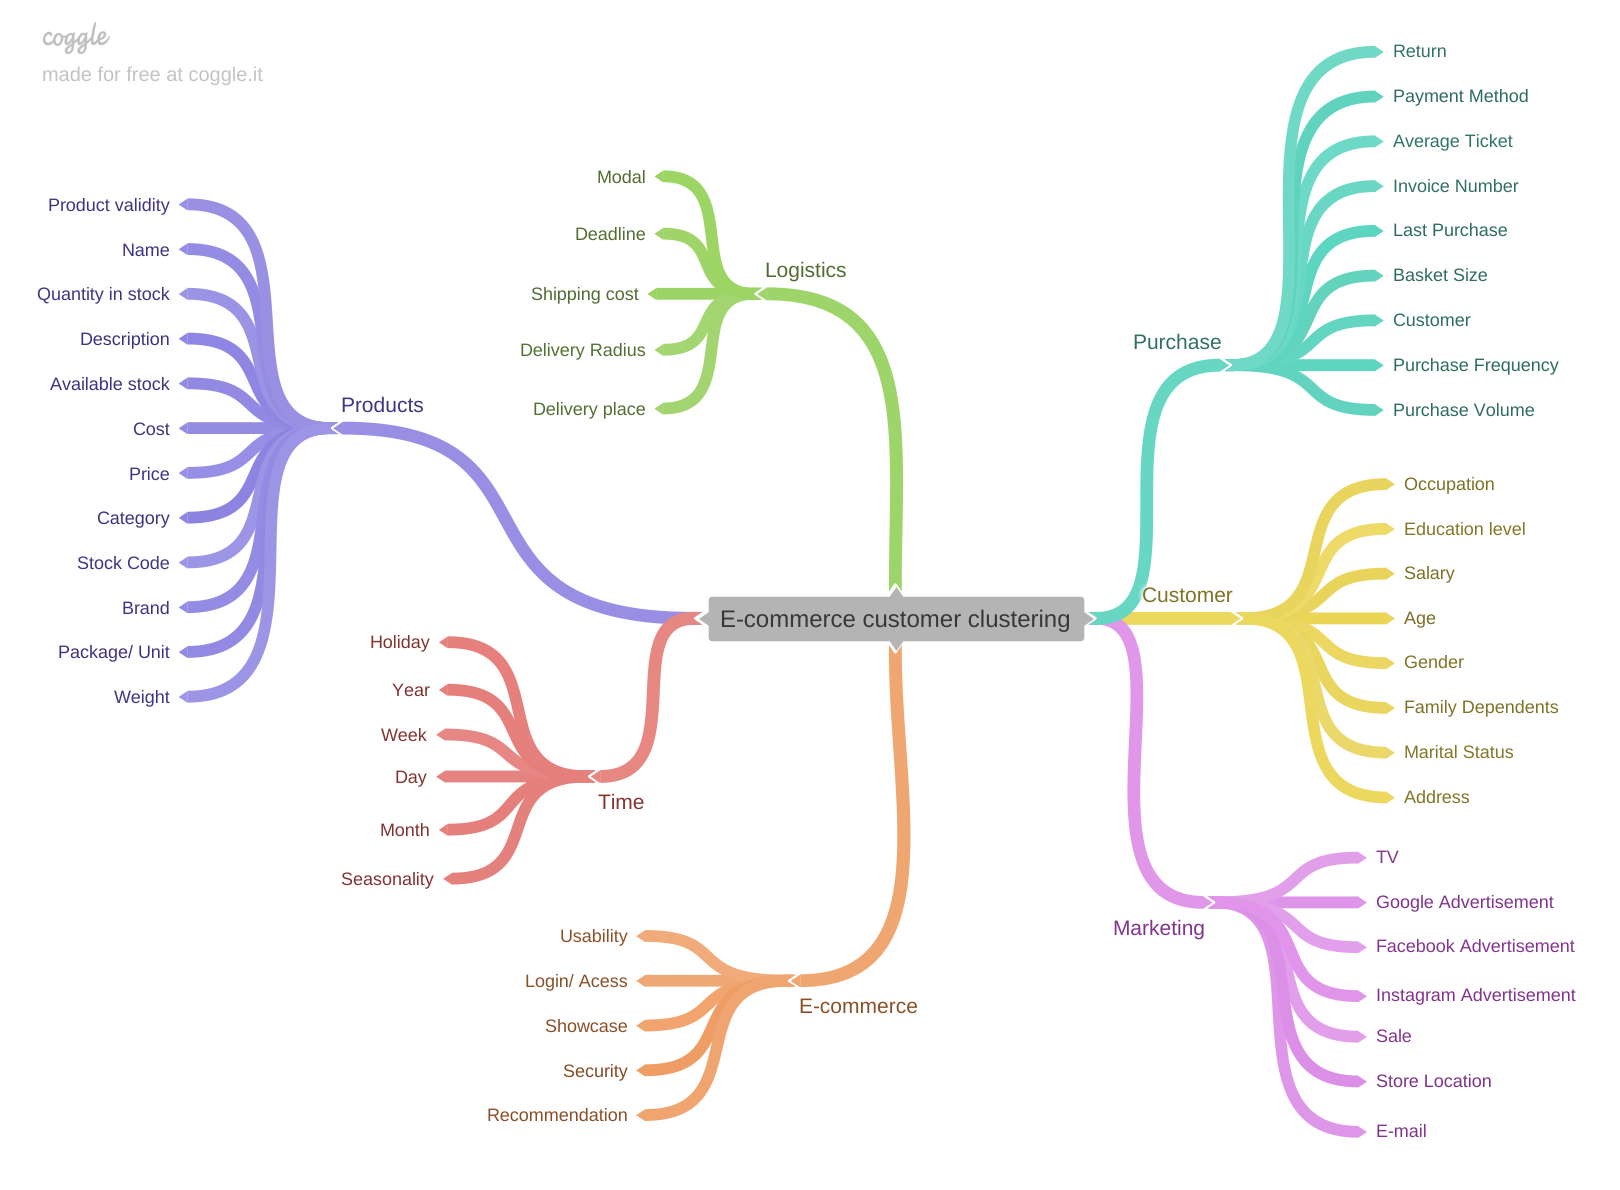

In [ ]:
display(Image(filename='../img/mind_map.png'))

### 11.1.1 - PURCHASE HIPOTHESYS

#### 1. OS Clientes do Cluster Diamonds possuem uma volumetria (Produtos) de compras acima de 30% do total de compras.


**True:** Customers from the Diamond cluster have a purchasing percentage of 55.38% over the base

In [474]:
diamond_sales = df_profile.loc[df_profile['cluster'] == 1, 'qtde_products'].sum()
total_sales = df_profile.loc[:, 'qtde_products'].sum()

print('Percentage of purchases made by Diamonds customers is {:,.2f}%'.format((diamond_sales / total_sales)*100))

Percentage of purchases made by Diamonds customers is 55.38%


#### 2. Os Clientes do Cluster Diamonds possuem uma volumetria (Faturamento) de compras acima de 30% do total de compras

**True:** Diamond custormers have a turnover of over 30%, representing 56.76% of the base's total purchasing revenue.

In [475]:
diamond_revenue = df_profile.loc[df_profile['cluster'] == 1, 'gross_revenue'].sum()
total_revenue = df_profile.loc[:, 'gross_revenue'].sum()
diamond_revenue = pd.to_numeric(diamond_revenue)
total_revenue = pd.to_numeric(total_revenue)
print('The percentage of revenue from purchases made by Diamonds customers is {:,.2f}%'.format((diamond_revenue / total_revenue)*100))

The percentage of revenue from purchases made by Diamonds customers is 56.76%


#### 3. Clientes do Cluster Diamonds possuem quantidade de devolução média abaixo da media da base total.

**False:** The average number of returns from customers in the Diamond cluster is higher than that of the rest of the base, corresponding to 80.38%

In [ ]:
avg_diamond_returns = df_profile.loc[df_profile['cluster'] == 1, 'qtde_returns'].mean()
avg_return_all = df_profile['qtde_returns'].mean()
print('Average returns made by Diamond clusters is {:.0f}, corresponding to {:.2f}%.'.format(avg_diamond_returns, np.abs(((avg_return_all / avg_diamond_returns)*100) - 100)))
print('Average returns from the rest of the base is {:.0f}'.format(avg_return_all))

Average returns made by Diamond clusters is 299, corresponding to 80.38%.
Average returns from the rest of the base is 59


#### 4. A mediana do faturamento pelos clientes do cluster Diamonds é 15% maior comparado com a mediana de todos os outros produtos

**True:** The median revenue of the Diamond cluster corresponds to 289.69%

In [ ]:
median_diamond = df_profile.loc[df_profile['cluster'] == 1, 'gross_revenue'].median()
median_all = df_profile['gross_revenue'].median()  # Removido a seleção para pegar o valor único

result = ((median_diamond - median_all) / median_all) * 100
print('The Diamond cluster median revenue is {:,.2f}% higher compared to the rest of the base.'.format(result))


The Diamond cluster median revenue is 289.69% higher compared to the rest of the base.


#### 5. O percentil do faturamento pelos clientes Diamonds

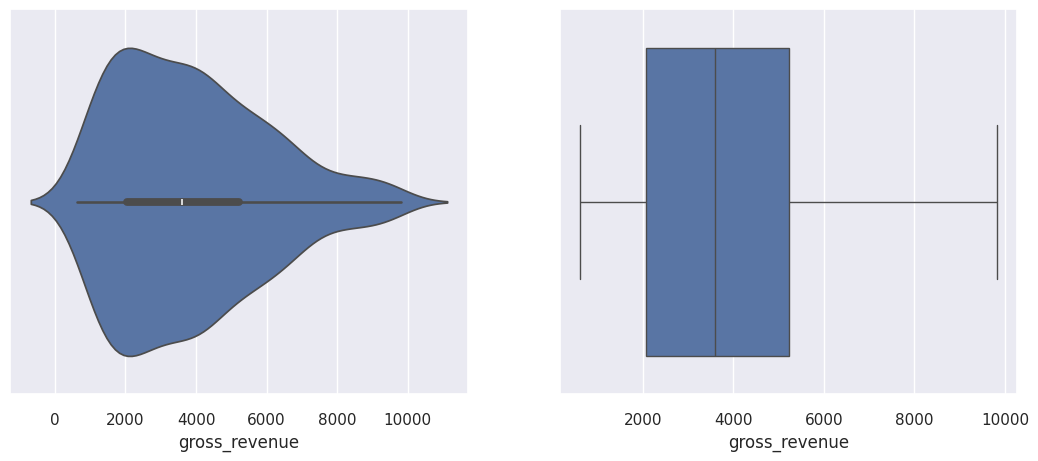

In [ ]:
df_aux = df_profile.loc[(df_profile['cluster'] == 1) & (df_profile['gross_revenue'] < 10000), 'gross_revenue']
plt.subplot(1,2,1)
sns.violinplot(x = df_aux)

plt.subplot(1,2,2)
sns.boxplot(x = df_aux)
plt.show()

### 11.1.2 - BUSINESS QUESTIONS

#### Relatório com as respostas para as perguntas de negocio:

#### Quem são as pessoas elegíveis para participar do programa **Diamond**?


In [ ]:
df_profile[['customer_id', 'cluster']].loc[df_profile['cluster'] == 1].head(10)

,customer_id,cluster
0,17850,1
2,12583,1
6,14688,1
8,15311,1
12,16029,1
14,12431,1
15,17511,1
19,13408,1
20,13767,1
22,13448,1


#### Quantos customers farão parte do programa?

In [ ]:
print('The number of customers eligible to participate in Diamond are: {}'.format(len(df_profile.loc[df_profile['cluster'] == 1])))

The number of customers eligible to participate in Diamond are: 487


#### Quais as principais caracteristicas desses clientes?

 DIAMOND - CLUSTER 01 (Candidate High Value Customer):
 - Total of customers: 487 (16.03% of all customers)
 - Average of Gross Revenue: $9,544.57
 - Average of Recency Days: 20
 - Average of invoice number: 419
 - Average of Returns: 298
 - Average Purchase Frequency: 0.09%

#### Qual o percentual de contribuição  do faturamento, vinda dos customers participantes?

In [ ]:
diamond_revenue = df_profile.loc[df_profile['cluster'] == 1, 'gross_revenue'].sum()
total_revenue = df_profile.loc[:, 'gross_revenue'].sum()
diamond_revenue = pd.to_numeric(diamond_revenue)
total_revenue = pd.to_numeric(total_revenue)
print('The percentage of revenue from purchases made by Diamonds customers is {:,.2f}%'.format((diamond_revenue / total_revenue)*100))

The percentage of revenue from purchases made by Diamonds customers is 56.76%


#### Qual a expectativa de faturamento desse grupo para os proximos meses?

#### Quais as condições para um cliente ser removido do programa?

#### Qual a garantia da eficacia do programa para o restante da base?

#### Quais ações o squad de marketing pode realizar para aumentar o faturamento?

## 11.2 - PRIORITY OF HIPOTHESYS